In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [ ]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

 74%|████████████████████████████████████████████████████████▉                    | 1078/1457 [00:10<00:03, 102.90it/s]

In [ ]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
import random
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [ ]:

# building a linear stack of layers with the sequential model
model_cnn = Sequential()
# convolutional layer
model_cnn.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(200,200,3)))
model_cnn.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model_cnn.add(Flatten())
# hidden layer
model_cnn.add(Dense(100, activation='relu'))
# output layer
model._cnnadd(Dense(10, activation='softmax'))

# compiling the sequential model
model_cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
history_cnn=model.fit(x_train, y_train, batch_size=229, epochs=50, validation_data=(x_test, y_test))

In [3]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn.history['loss'],'r',linewidth=3.0)
plt.plot(history_cnn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_cnn.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_cnn.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

41/41 [==============================] - 68s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.95      0.97      0.96       306
           2       0.97      0.99      0.98       405
           3       1.00      0.97      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



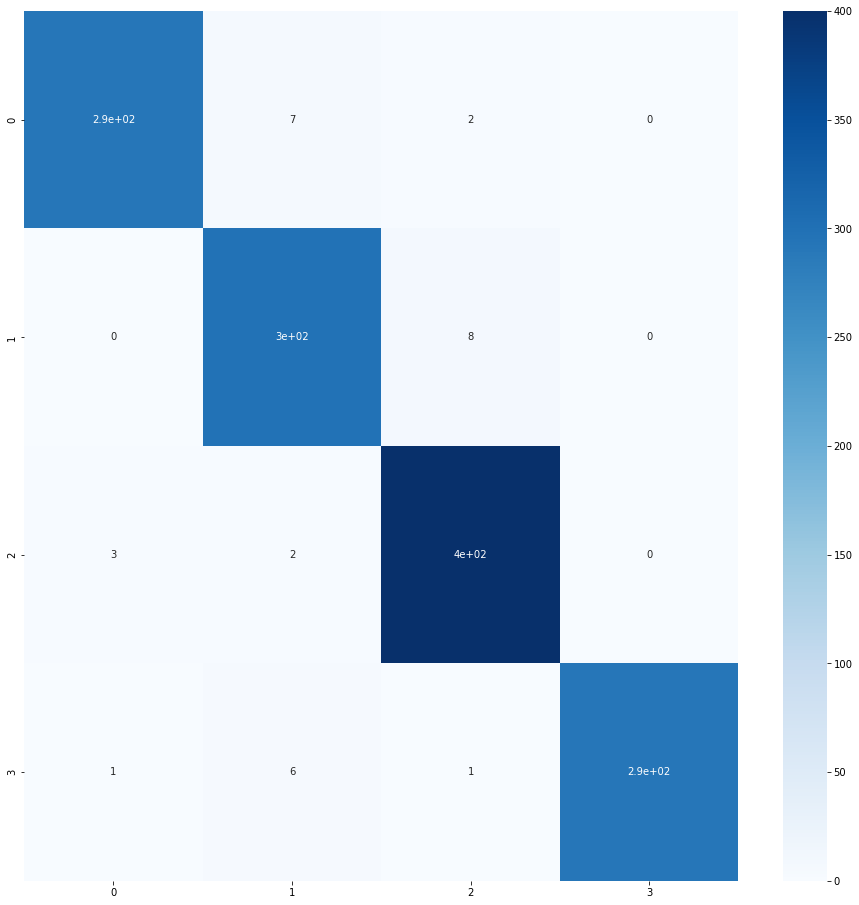

In [14]:
predicted_classes_cnn = np.argmax(model_cnn.predict(x_test), axis = 1)
confusionmatrix_cnn = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes_cnn)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix_cnn, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes_cnn))

In [15]:
loss,acc = model_cnn.evaluate(x_test,y_test)

41/41 [==============================] - 69s 2s/step - loss: 0.1300 - accuracy: 0.9771


In [ ]:

BATCH_SIZE = 64
EPOCHS = 50

Checkpoint_inceptionV3 = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES_inceptionV3 = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL_inceptionV3 = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks_inceptionV3 = [ES_inceptionV3,RL_inceptionV3,Checkpoint_inceptionV3,LambdaCallback(on_epoch_end=log_confusion_matrix_inceptionV3)]

history_inceptionV3 = model_inceptionV3.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks_inceptionV3)

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_inceptionV3.history['loss'],'r',linewidth=3.0)
plt.plot(history_inceptionV3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_inceptionV3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_inceptionV3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()